In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data = pd.read_csv('Yearly-train.csv')
data = data.dropna()
data = np.array(data.iloc[:,1:832])
data.reshape(1, -1)
data.shape

11807.26

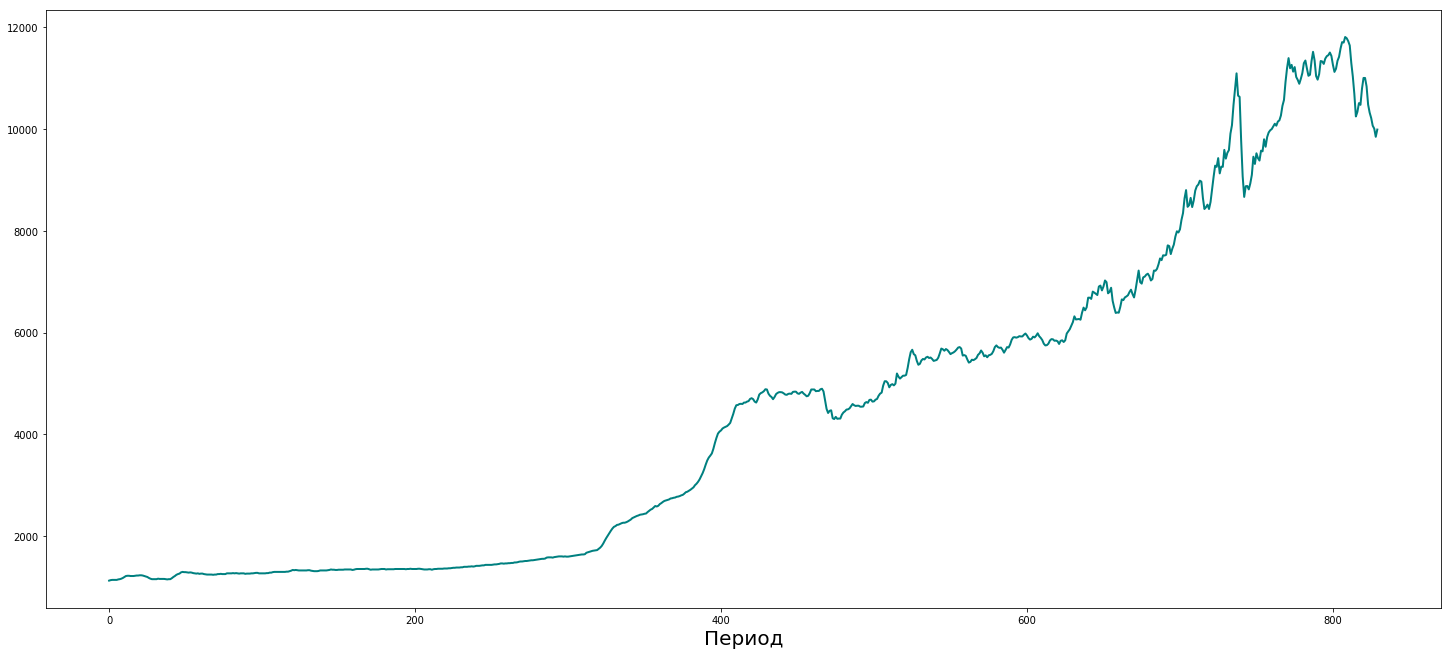

In [3]:
plt.figure(figsize = (25,11))    
plt.plot(range(830), data[0, 1:], c='teal', linewidth = '2')
plt.xlabel('Период', fontsize=20)
plt.savefig('data.jpg')
plt.show()

In [4]:
train_data = data[:,:781].reshape(-1, 1)
test_data = data[:,781:].reshape(-1, 1)

(781, 1)

In [5]:
scaler = MinMaxScaler()
size = 200
for di in range(0, 781, size):
    train_data[di:di+size,:] = scaler.fit_transform(train_data[di:di+size,:])

train_data[di:di+size] = scaler.fit_transform(train_data[di:di+size])
scaler.fit(test_data)
test_data = scaler.transform(test_data)
test_data = test_data.reshape(-1, 50, 1)

(1, 50, 1)

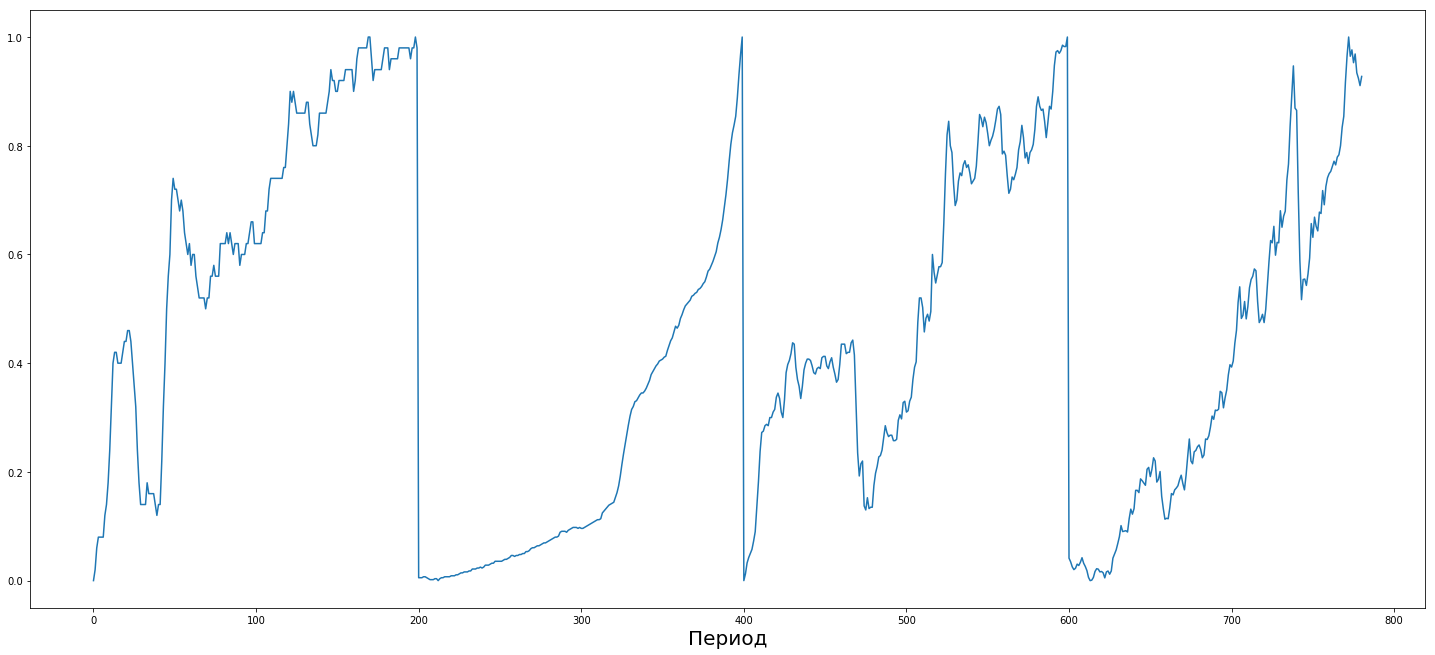

In [7]:
plt.figure(figsize = (25,11))  
plt.plot(range(781), train_data)
plt.xlabel('Период', fontsize=20)
plt.savefig('norm_data.jpg')
plt.show()

In [8]:
num_periods = 50
step = 1
train_data = train_data.reshape(-1)
x_data = train_data[:(len(train_data)-(len(train_data) % num_periods))]
x_batches = x_data.reshape(-1, 50, 1)

y_data = train_data[1:(len(train_data)-(len(train_data) % num_periods))+step]
y_batches = y_data.reshape(-1, 50, 1)

15
(15, 50, 1)
(15, 50, 1)


In [9]:
tf.reset_default_graph()

In [10]:
num_periods = 50
inputs = 1
hidden_layers = 100
output = 1

In [11]:
x = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

In [12]:
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units = hidden_layers, activation = tf.nn.relu)
rnn_output, previous_state = tf.nn.dynamic_rnn(basic_cell,x ,dtype=tf.float32)

In [13]:
stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden_layers])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output]) 

In [14]:
learning_rate = 0.01

In [15]:
loss =tf.reduce_sum(tf.square(outputs - y)) / int(outputs.shape[1])
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(loss)

In [16]:
init = tf.global_variables_initializer()

In [17]:
epochs = 1000
with tf.Session() as sess:
    init.run()
    losses=[]
    for ep in range(epochs):
        sess.run(train_op, feed_dict={x: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={x: x_batches, y: y_batches})
            losses.append(mse)
            print (ep, "\tMSE:", mse)
            
    y_pred = sess.run(outputs, feed_dict={x: test_data})


0 	MSE: 0.27224845
100 	MSE: 0.07114297
200 	MSE: 0.06425515
300 	MSE: 0.061823256
400 	MSE: 0.05978895
500 	MSE: 0.064860746
600 	MSE: 0.057521738
700 	MSE: 0.060832363
800 	MSE: 0.05663346
900 	MSE: 0.058352303


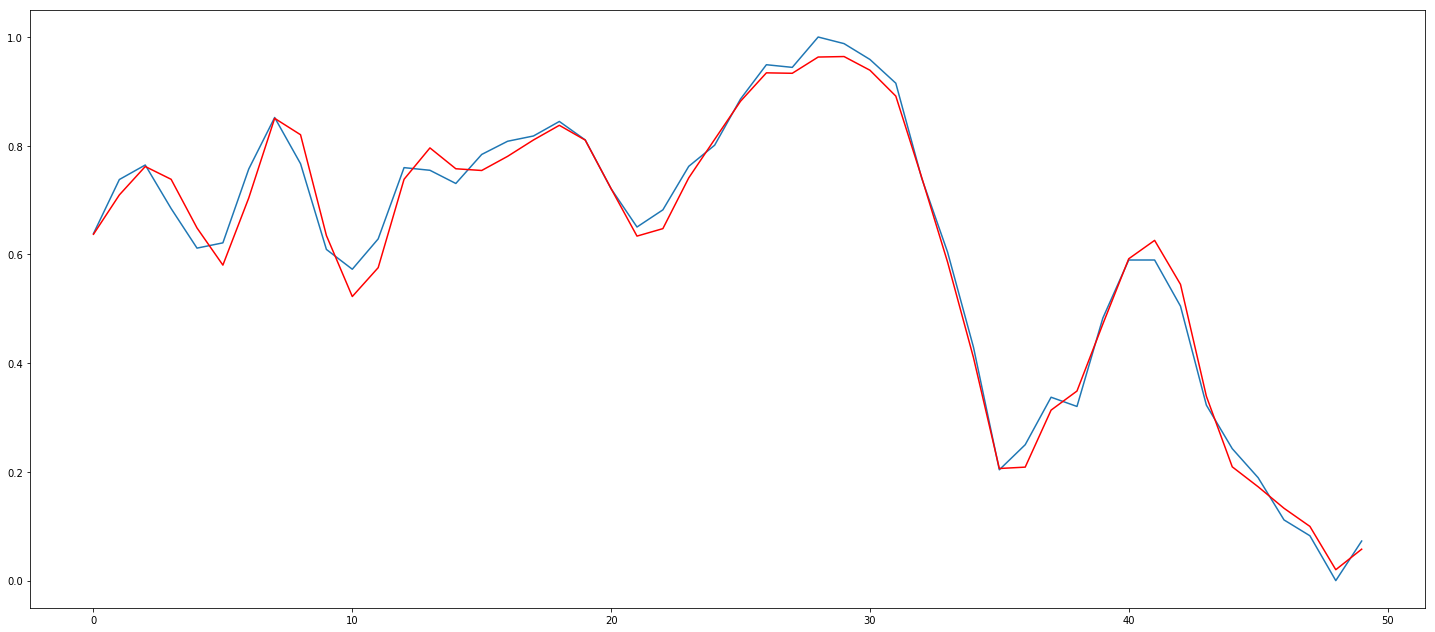

In [18]:
new_data = np.concatenate([train_data.reshape(-1), test_data.reshape(-1)])
plt.figure(figsize = (25,11)) 
y_pred = np.array(np.ravel(y_pred))
plt.plot(range(50),new_data[-50:])
plt.plot(range(50),y_pred, c='r')
plt.savefig('model_result.jpg')
plt.show()